# Music Genre Classification

We will build a music genre classifier using a DNN model and trained on the [GTZAN](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification/activity) genre classification dataset

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers

In [37]:
#we store our data in gdrive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Dataset

The GTZAN genre classification dataset contains 1000 audio tracks, each 30 seconds long, and contains 10 genres, specifically:
- Blues
- Classical
- Country
- Disco
- Hip-hop
- Jazz
- Metal
- Pop
- Reggae
- Rock

The dataset contains an original genres folder which contains the raw music samples, as well as an original images folder containing image representations of the songs (ie thumbnails, artwork), and 2 csv files containing features of the audio files.

In our case, we have our data CSVs stored in our google drive, you can adjust the file upload to your preference.

In [38]:
df = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/projects/music_genres/features_3_sec.csv")

#drop first column
df = df.drop(labels='filename', axis=1)

Take a sample audio recording for feature analysis:

In [39]:
audio_recording = "/gdrive/MyDrive/Colab Notebooks/projects/music_genres/country.00075.wav"
data, sr = librosa.load(audio_recording)

## Data Visualization

There are multiple methods of visualizing the features of audio files. We will investiage a few popular methods before data preprocessing.

### 1. Raw Wave Files

Raw wave files represent audio files by measuring amplitude over time.

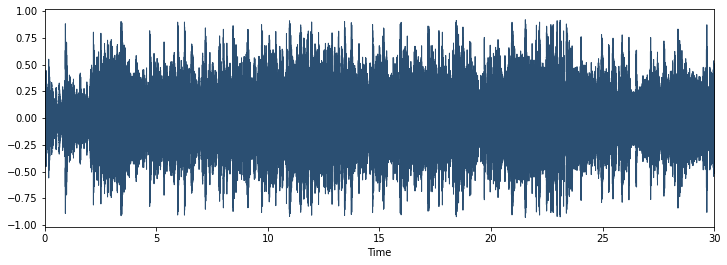

In [40]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, color="#2B4F72")
plt.show()

### 2. Spectograms

Spectograms visualize the signal loudness of a signal over time at various frequencies present in a particular waveform.

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


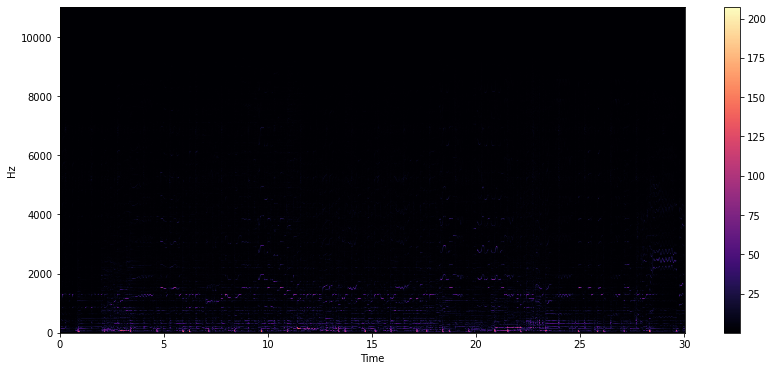

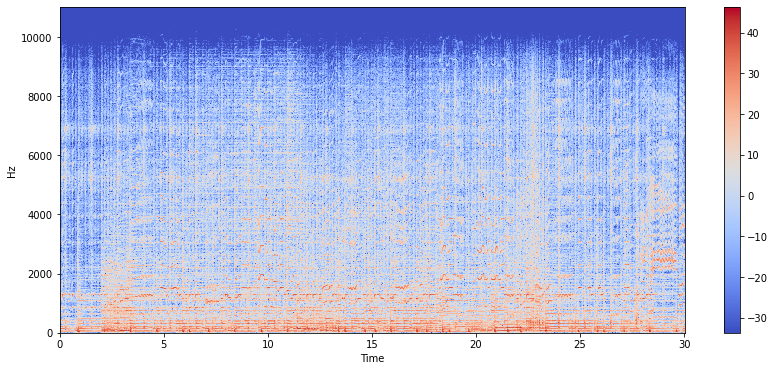

In [41]:
spec = librosa.stft(data)
spec_db = librosa.amplitude_to_db(abs(spec))

#plot spectogram with amplitude
plt.figure(figsize=(14, 6))
librosa.display.specshow(spec, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

#plot spectogram with db
plt.figure(figsize=(14, 6))
librosa.display.specshow(spec_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

### 3. Spectral Rolloff

We can visualize the frequencies below which a specified spectral energy lies for an audio clip.

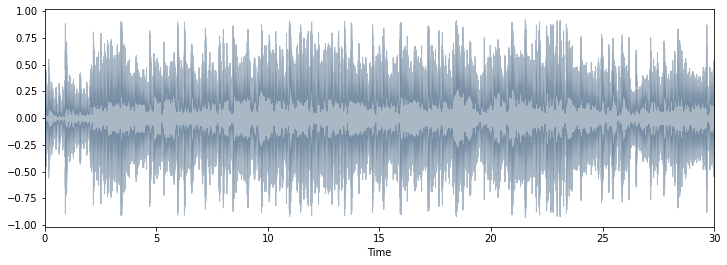

In [42]:
from sklearn.preprocessing import normalize
spec_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color="#2B4F72")
plt.show()

### 4. Chroma Feature

We can capture harmonic and melodic characteristics of audio clips while being robust to changes in timbre and instrumentation. So we can analyze music features whose pitches can be meaningfully categorized.

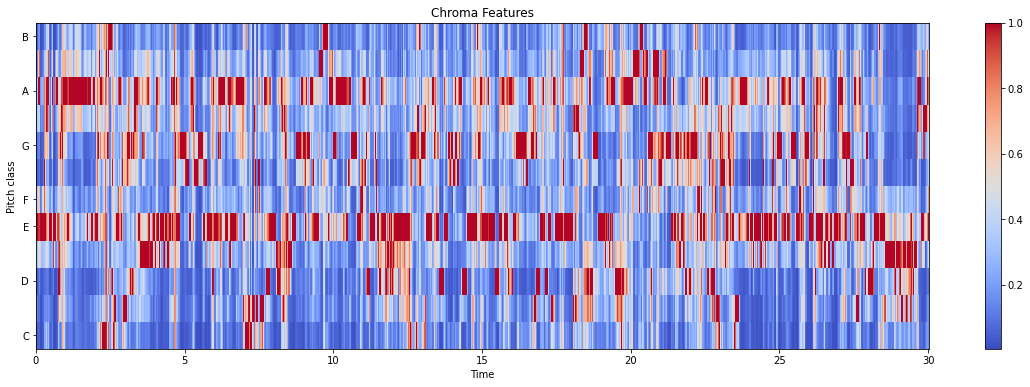

In [44]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(20,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

### 5. Zero Crossing Rate

We can capture the number of times in a given time interval/frame that the amplitude of speech signals passes through a value of zero in an audio sample.

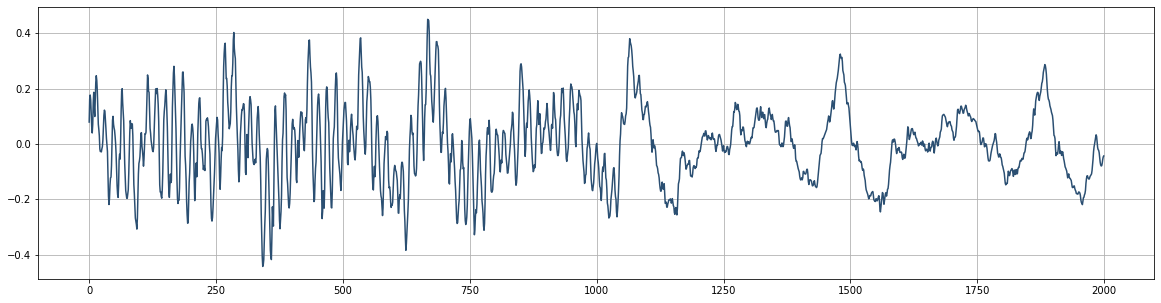

In [51]:
plt.figure(figsize=[20,5])
plt.plot(data[0:2000], color="#2B4F72")
plt.grid()

In [50]:
zero_cross_rate = librosa.zero_crossings(data[0:2000], pad=False)
print("Number of zero-crossings in interval [0,2000]: ", sum(zero_cross_rate))

Number of zero-crossings in interval [0,2000]:  165


### Feature Preprocessing

First factorize any categorical labels, specifically map the labels to numbers. 

In [60]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()
y = convertor.fit_transform(class_list)

Then normalize features via feature scaling

In [61]:
from sklearn.preprocessing import StandardScaler
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype=float))

Split data into training, validation and testing set

In [110]:
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size = 0.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size = 0.25)

### Model Definition

We define our model and training loop as follows:
- Our model architecture will follow a simple DNN with RELU activations and dropout regularization, with softmax output activation to classify one of the 10 music genres.
- Since there are multiple classes and they're encoded as scalar integers, we use `sparse_categorical_crossentropy` loss 
- We use adam optimizer with default params, with accuracy as our metric

In [90]:
#constants
BATCH_SIZE = 128
DROPOUT_RATE = 0.3

In [85]:
def train_model(model, epochs, opt):
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='accuracy')
  return model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=BATCH_SIZE)

def plotValidate(history):
  pd.DataFrame(history.history).plot(figsize=(12,6))
  plt.show()

In [111]:
model = Sequential([
  layers.Dense(512, 'relu', input_shape=(X_train.shape[1],)),
  layers.Dropout(DROPOUT_RATE),

  layers.Dense(256, 'relu'),
  layers.Dropout(DROPOUT_RATE),

  layers.Dense(128, 'relu'),
  layers.Dropout(DROPOUT_RATE),

  layers.Dense(64, 'relu'),
  layers.Dropout(DROPOUT_RATE),

  layers.Dense(10, 'softmax'),
])

### Train and Evaluate Model

In [112]:
model_history = train_model(model=model, epochs=100, opt='adam')

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 1.8102 - accuracy: 0.3549 - val_loss: 1.2646 - val_accuracy: 0.5456
Epoch 2/100
55/55 [==============================] - 0s 5ms/step - loss: 1.3427 - accuracy: 0.5234 - val_loss: 1.0074 - val_accuracy: 0.6627
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 1.1225 - accuracy: 0.6109 - val_loss: 0.8598 - val_accuracy: 0.7161
Epoch 4/100
55/55 [==============================] - 0s 6ms/step - loss: 1.0065 - accuracy: 0.6581 - val_loss: 0.7481 - val_accuracy: 0.7517
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.8943 - accuracy: 0.6970 - val_loss: 0.6886 - val_accuracy: 0.7815
Epoch 6/100
55/55 [==============================] - 0s 6ms/step - loss: 0.8247 - accuracy: 0.7219 - val_loss: 0.6589 - val_accuracy: 0.7721
Epoch 7/100
55/55 [==============================] - 0s 6ms/step - loss: 0.7474 - accuracy: 0.7495 - val_loss: 0.6078 - val_accuracy: 0.7864
Epoch 8/100
5

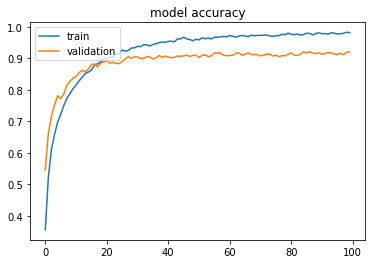

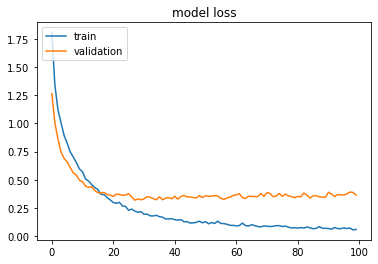

In [113]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel = 'accuracy'
plt.xlabel = 'epoch'
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel = 'loss'
plt.xlabel = 'epoch'
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Finally, evaluate the model against the test set:

In [114]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test loss: ", test_loss)
print("Test Accuracy: ", test_acc*100)

6/6 [==============================] - 0s 4ms/step - loss: 0.4034 - accuracy: 0.9027
Test loss:  0.40335628390312195
Test Accuracy:  90.2666687965393
